In [2]:
!pip install hdbscan pymatgen -q

^C
ERROR: Operation cancelled by user


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import hdbscan
import os
import json

import sys
sys.path.append('..')
sys.path.append('../autoencoder')


from fastai import *
from fastai.vision.all import *

from src.band_plotters import *
from src.TensorImageNoised import *
from src.transforms import Binarize

sys.path.append('/notebooks/band-fingerprint/autoencoder/resnet_autoencoder')
from model import *

In [2]:
DATA_DIRECTORY = Path("/storage/materials_project/images")

# Select Fingerprint Name and Length Here:

In [3]:
FINGERPRINT_LENGTH = 98
FINGERPRINT_NAME = "224_2channel_resnet_L={0}".format(FINGERPRINT_LENGTH)

# WIDTH=224
PERPLEXITY = 30
OUTPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"
print(FINGERPRINT_NAME)

224_2channel_resnet_L=98


To make a new fingerprint all you need to change is the constants above and/or the calc_fingerprint function below.

# Start with Anupam's list of materials

In [6]:
df_material = pd.read_csv("../fingerprints/materials_project/df_full_structure.csv", index_col="material_id")
df_material = df_material[["flat", "formula"]]
df_material.head()

,flat,formula
material_id,,
mp-7,True,S
mp-25,True,N2
mp-35,True,Mn
mp-43,True,U
mp-83,True,S


# Fingerprint Functions Here
Fingerprint functions take material ID as only input

## Resnet AE

In [7]:
def run_resnet_one_mat(material_id, CNN_model, input_band_image_type, data_directory=DATA_DIRECTORY):
        image_filename = data_directory/f"{material_id}.png"
        
        # Use the dataloaders to preprocess the input image
        dl = CNN_model.dls.test_dl([image_filename])
        # Forward pass through the encoder
        with torch.no_grad():
            encoded_representation = CNN_model.model.encoder(dl.one_batch()[0])
        #out = trained_model.encoder(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/2dm-4.png")

        
        # flatten encoded 2d array representation of the band structure as the fingerprint
        return encoded_representation.flatten().detach().numpy()

# resnet_input_file_type = "grayscale_4ev_linewidth3"
# change path to the location of the desired trained model
model_name = "resnet18"
model_path = f"../autoencoder/models/mp_models/{model_name}.pkl"
resnet_model = load_learner(model_path)

fingerprint = run_resnet_one_mat("mp-88", resnet_model, "")
print(fingerprint)
print(len(fingerprint))

[0.19057909 0.0871634  2.9363995  2.9847589  3.5717373  3.5603118
 2.9724271  0.10542203 0.23998821 5.195095   4.2632217  4.3253784
 4.9800844  2.2932851  0.10291772 0.21524562 3.6416123  3.6008482
 4.0520525  5.783118   3.064374   0.05787613 0.15349604 1.6496515
 4.633303   4.105718   5.030265   3.113788   0.05355439 0.34076115
 2.2509816  5.770562   3.7597454  3.5395327  2.7153192  0.03148469
 0.22108981 1.8660498  3.8944025  3.0306997  4.3384824  1.4494731
 0.14381202 0.31159383 3.1707666  2.396067   3.3490524  3.4311388
 1.2637639  0.23619448 4.0588193  0.8432996  2.804359   3.197901
 3.0828297  0.4685945  0.11600085 6.8483624  0.         3.8048346
 2.5130029  4.211054   0.47143137 0.1020326  7.016394   0.6679641
 3.6065588  3.8384995  3.5807028  0.5194986  0.0904058  4.189587
 0.6612454  1.9524806  3.6530461  4.3780017  0.48149702 0.12242276
 3.405908   0.65702826 3.008779   2.5559523  3.755053   0.44755787
 0.14760174 3.820825   0.14653997 2.4601145  2.8222945  3.02344
 0.5708799

## View All Fingerprint Functions

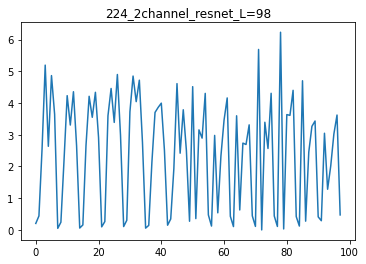

In [8]:
fingerprint_functions = {
    "224_2channel_resnet_L={0}".format(FINGERPRINT_LENGTH): lambda x: run_resnet_one_mat(x, resnet_model, "", data_directory=DATA_DIRECTORY),    
}


for fingerprint_name in fingerprint_functions: 
    fp = fingerprint_functions[fingerprint_name]("mp-8")
    plt.plot(fp)
    plt.title(fingerprint_name)
    plt.show()
    

In [9]:
fingerprint_array = np.zeros([len(df_material), FINGERPRINT_LENGTH])

In [10]:
for i, material_id in enumerate(df_material.index):
    if i % 100 == 0:
        print(i, "/", len(df_material))

    fingerprint_array[i, :] = fingerprint_functions[FINGERPRINT_NAME](material_id)

print(fingerprint_array)

0 / 33251
100 / 33251
200 / 33251
300 / 33251
400 / 33251
500 / 33251
600 / 33251
700 / 33251
800 / 33251
900 / 33251
1000 / 33251
1100 / 33251
1200 / 33251
1300 / 33251
1400 / 33251
1500 / 33251
1600 / 33251
1700 / 33251
1800 / 33251
1900 / 33251
2000 / 33251
2100 / 33251
2200 / 33251
2300 / 33251
2400 / 33251
2500 / 33251
2600 / 33251
2700 / 33251
2800 / 33251
2900 / 33251
3000 / 33251
3100 / 33251
3200 / 33251
3300 / 33251
3400 / 33251
3500 / 33251
3600 / 33251
3700 / 33251
3800 / 33251
3900 / 33251
4000 / 33251
4100 / 33251
4200 / 33251
4300 / 33251
4400 / 33251
4500 / 33251
4600 / 33251
4700 / 33251
4800 / 33251
4900 / 33251
5000 / 33251
5100 / 33251
5200 / 33251
5300 / 33251
5400 / 33251
5500 / 33251
5600 / 33251
5700 / 33251
5800 / 33251
5900 / 33251
6000 / 33251
6100 / 33251
6200 / 33251
6300 / 33251
6400 / 33251
6500 / 33251
6600 / 33251
6700 / 33251
6800 / 33251
6900 / 33251
7000 / 33251
7100 / 33251
7200 / 33251
7300 / 33251
7400 / 33251
7500 / 33251
7600 / 33251
7700 / 3325

In [11]:
#check for NaNs 
np.isnan(fingerprint_array).sum()
print(len(fingerprint_array))

33251


# Create T-SNE Reduced Dimension Fingerprints

In [12]:
tsne = manifold.TSNE(n_components=2, early_exaggeration=100.0, init="pca",learning_rate=100, random_state=0, perplexity=PERPLEXITY ,n_iter=10000, verbose=2)
fingerprint_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 33251 samples in 0.003s...
[t-SNE] Computed neighbors for 33251 samples in 3.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 33251
[t-SNE] Computed conditional probabilities for sample 2000 / 33251
[t-SNE] Computed conditional probabilities for sample 3000 / 33251
[t-SNE] Computed conditional probabilities for sample 4000 / 33251
[t-SNE] Computed conditional probabilities for sample 5000 / 33251
[t-SNE] Computed conditional probabilities for sample 6000 / 33251
[t-SNE] Computed conditional probabilities for sample 7000 / 33251
[t-SNE] Computed conditional probabilities for sample 8000 / 33251
[t-SNE] Computed conditional probabilities for sample 9000 / 33251
[t-SNE] Computed conditional probabilities for sample 10000 / 33251
[t-SNE] Computed conditional probabilities for sample 11000 / 33251
[t-SNE] Computed conditional probabilities for sample 12000 / 33251
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 1033.4295654, gradient norm = 0.0628185 (50 iterations in 9.364s)
[t-SNE] Iteration 100: error = 1106.0125732, gradient norm = 0.0165493 (50 iterations in 10.490s)
[t-SNE] Iteration 150: error = 1119.7451172, gradient norm = 0.0142606 (50 iterations in 8.585s)
[t-SNE] Iteration 200: error = 1122.7612305, gradient norm = 0.0011592 (50 iterations in 9.834s)
[t-SNE] Iteration 250: error = 1123.9415283, gradient norm = 0.0006429 (50 iterations in 9.744s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1123.941528
[t-SNE] Iteration 300: error = 5.5627818, gradient norm = 0.0024159 (50 iterations in 9.730s)
[t-SNE] Iteration 350: error = 4.3814902, gradient norm = 0.0011926 (50 iterations in 11.215s)
[t-SNE] Iteration 400: error = 3.9212487, gradient norm = 0.0006919 (50 iterations in 9.921s)
[t-SNE] Iteration 450: error = 3.6486907, gradient norm = 0.0004809 (50 iterations in 8.397s)
[t-SNE] Iteration 500: error = 3.4582024, gradient norm = 

# Quick cluster (not saved) and plots to check fingerprint and T-SNE worked

In [13]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='manhattan', cluster_selection_method='leaf', min_cluster_size=4, min_samples=2, p=0.2)
clusterer.fit(fingerprint_array)
labels = clusterer.labels_

Text(0.5, 1.0, 'fingerprint_length=98')

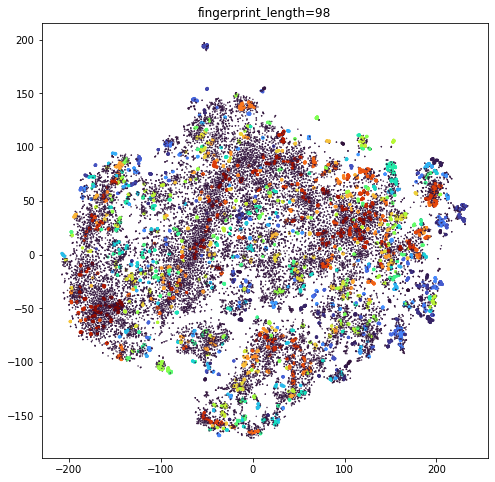

In [14]:
fig, ax  = plt.subplots(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

ax.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")
plt.title("fingerprint_length={0}".format(FINGERPRINT_LENGTH))

# Add fingerprints, T-SNE to dataframe

In [15]:
df = df_material.join(pd.DataFrame(fingerprint_array, index=df_material.index))
df["fx"] = fingerprint_2d[:, 0]
df["fy"] = fingerprint_2d[:, 1]
df["labels"] = labels
df.head()

,flat,formula,0,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,fx,fy,labels
material_id,,,,,,,,,,,,,,,,,,,,,
mp-7,True,S,0.245463,0.316609,2.711195,5.020233,3.466096,4.648217,3.002772,0.078223,...,0.270387,4.220656,0.966594,3.354174,3.288572,4.950653,0.443941,-56.053104,72.436493,-1
mp-25,True,N2,0.232902,0.166350,2.056056,2.607353,2.355176,2.417567,2.084737,0.123120,...,0.300599,6.560693,0.322889,2.472004,1.891247,4.689752,0.441909,-150.908951,-3.345328,-1
mp-35,True,Mn,0.214138,0.262391,2.627867,3.983955,3.478712,3.864387,2.785767,0.078916,...,0.286841,4.366640,0.476839,3.077687,3.280831,4.112584,0.478588,100.028694,36.410027,-1
mp-43,True,U,0.165381,0.179475,2.933744,2.749684,3.004366,3.191262,3.304118,0.073473,...,0.289611,4.458014,0.783094,3.097659,2.912135,4.089445,0.418095,52.899170,-7.270276,-1
mp-83,True,S,0.235596,0.355912,3.457191,5.099987,4.096745,4.074076,2.868982,0.065553,...,0.286050,5.509573,0.477994,2.565539,3.385070,4.754420,0.482432,-35.486671,58.252205,-1


In [22]:
df = df.drop("flat", axis=1)
df.to_csv(f"../fingerprints/materials_project/df_{model_name}.csv")